In [31]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import models_Segmentation
from util.metrics import SegmentationMetric

import sys
sys.path.append('./modules/')

from mypath import Path
from dataloaders import make_data_loader
from modeling.deeplab import *
from modeling.Unet_models import *
from utils.loss import SegmentationLosses
from utils.calculate_weights import calculate_weigths_labels
from utils.lr_scheduler import LR_Scheduler
from utils.saver import Saver
from utils.summaries import TensorboardSummary
from utils.metrics import Evaluator

## Define utils

In [43]:
import matplotlib as mpl
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

def show_image(image, vmin=None, vmax=None, title='', figsize=None,cmap=None):
    if figsize is not None:
        plt.figure(figsize=figsize)
    if cmap:
        plt.imshow(image, cmap=cmap, interpolation='bicubic', vmin=vmin, vmax=vmax)
    else:
        plt.imshow(image, interpolation='bicubic', vmin=vmin, vmax=vmax)
#     plt.title(title,y=-0.06)
    plt.axis('off')
    # plt.show()
    return

In [33]:
def prepare_model(chkpt_dir, arch='vit_large_patch16', img_size=768):
    model = getattr(models_Segmentation, arch)(num_classes=6, 
                                      drop_path_rate=0.1, 
                                      in_chans=1, 
                                      img_size=img_size,
                                      global_pool=False,
                                      )
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
#     interpolate_pos_embed(model, checkpoint['model'])
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model 

In [34]:
#SFM-Fine-tune
chkpt_dir = './modelbase/checkpoint-99.pth' 
model_vit_base = prepare_model(chkpt_dir, 'vit_base_patch16', img_size=768)
#SFM-Frozen
chkpt_dir = './modelbase_forzen/checkpoint-99.pth' 
model_vit_base_frozen = prepare_model(chkpt_dir, 'vit_base_patch16', img_size=768)
#Transformer-From-Scratch
chkpt_dir = './modelbase_scratch/checkpoint-99.pth' 
model_vit_base_scratch = prepare_model(chkpt_dir, 'vit_base_patch16', img_size=768)
#SFM-Fine-tune-512
chkpt_dir = './modelbase_512/checkpoint-99.pth' 
model_vit_base_512 = prepare_model(chkpt_dir, 'vit_base_patch16', img_size=768)
#Deeplab
model_deeplab = DeepLab(num_classes=6,
                backbone='resnet',
                output_stride=16,
                sync_bn=False,
                freeze_bn=False)
model_deeplab.eval()
checkpoint = torch.load('./finetune_SEAM_deeplab/checkpoint-99.pth', map_location='cpu')
model_deeplab.load_state_dict(checkpoint['model'], strict=False)
#Unet
model_unet = U_Net(1, 6)
checkpoint = torch.load('./Unet/checkpoint-99.pth', map_location='cpu')
model_unet.load_state_dict(checkpoint['model'], strict=False)

<All keys matched successfully>


### Run finetune model to prediction the fault

In [40]:
def run_one_image(img, model, model2,model3=None,model4=None,model5=None,model6=None, label=None, clims=None, savefig=None,cmapl='Spectral'):
    model.eval()
    model2.eval()
    
    x = torch.tensor(img)
    x = x.unsqueeze(0)

    pred  = model(x)
    pred  = pred.argmax(dim=1).detach().cpu()
    pred = pred.squeeze(0)
    pred = pred.squeeze(0)
    

    pred2 = model2(x)
    pred2 = pred2.argmax(dim=1).detach().cpu()
    pred2 = pred2.squeeze(0)
    pred2 = pred2.squeeze(0)
    if model3:
            model3.eval()
            pred3 = model3(x)
            pred3 = pred3.argmax(dim=1).detach().cpu()
            pred3 = pred3.squeeze(0)
            pred3 = pred3.squeeze(0)
    if model4:
            model4.eval()
            pred4 = model4(x)
            pred4 = pred4.argmax(dim=1).detach().cpu()
            pred4 = pred4.squeeze(0)
            pred4 = pred4.squeeze(0)
    if model5:
            model5.eval()
            pred5 = model5(x)
            pred5 = pred5.argmax(dim=1).detach().cpu()
            pred5 = pred5.squeeze(0)
            pred5 = pred5.squeeze(0)  
    if model6:
            model6.eval()
            pred6 = model6(x)
            pred6 = pred6.argmax(dim=1).detach().cpu()
            pred6 = pred6.squeeze(0)
            pred6 = pred6.squeeze(0)  
    
    x = x.squeeze(0)
    x = x.squeeze(0)

    if clims is None:
        clims = [x.min(), x.max()]
    import matplotlib
    plt.rcParams['figure.figsize'] = [45, 15]
    matplotlib.rcParams.update({'font.size': 15})
    plt.rcParams['font.sans-serif']=['Arial']
    plt.subplots_adjust(wspace=0.05, hspace=0.2)
    Figurenum = 4
    if model3:
        Figurenum += 1
    if model4:
        Figurenum += 1
    if model5:
        Figurenum += 1
    if model6:
        Figurenum += 1
    plt.subplot(1,Figurenum, 1)
    show_image(x, vmin=clims[0]/12, vmax=clims[1]/12, title="Seismic",cmap=cmap)

    plt.subplot(1,Figurenum, 6)
    show_image(pred,cmap=cmapl, title="Transformer-Pretrained")

    plt.subplot(1,Figurenum, 4)
    show_image(pred2,cmap=cmapl, title="Transformer-Scratch")
    
    if model3:
            plt.subplot(1,Figurenum, 5)
            show_image(pred3,cmap=cmapl, title="Transformer-Forzen")
    if model4:
            plt.subplot(1,Figurenum, 3)
            show_image(pred4,cmap=cmapl, title="Deeplab")
    if model5:
            plt.subplot(1,Figurenum, 2)
            show_image(pred5,cmap=cmapl, title="Unet")
    if model6:
            plt.subplot(1,Figurenum, 7)
            show_image(pred6,cmap=cmapl, title="Transformer-512")       
    plt.subplot(1,Figurenum, Figurenum)
    show_image(label,cmap=cmapl, title="label")

    plt.subplots_adjust(wspace=0.05, hspace=0.05)
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight', dpi=300, pad_inches=0.0)

    plt.show()
    if model3:
        if model4:
            if model5:
                return pred,pred2,pred3,pred4,pred5
            return pred,pred2,pred3,pred4
        return pred,pred2,pred3
    return pred,pred2

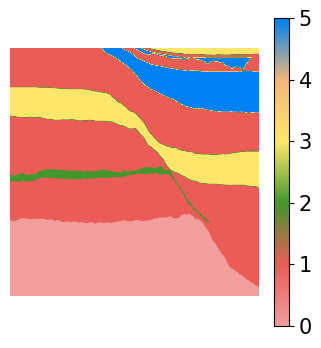

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import matplotlib as mpl

color_list = ['#F19E9C','#EB5C56','#43972B','#FEE76B','#F3B677','#0082F4'] #seam
cmapl = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)

data_list = ['../Data/Facies/' +'seismic/'+ str(f)+'.dat' for f in range(117)]
label_list = [f.replace('/seismic/', '/label/') for f in data_list]
dnum = 100
d = np.fromfile(data_list[dnum], np.float32)
d = d.reshape([1] + [768,768])
l = np.fromfile(label_list[dnum], np.float32).reshape([768,768])-1
l = l.astype(int)
plt.rcParams['figure.figsize'] = [4, 4]
plt.imshow(l,cmap=cmapl)
plt.axis('off')
# plt.colorbar()

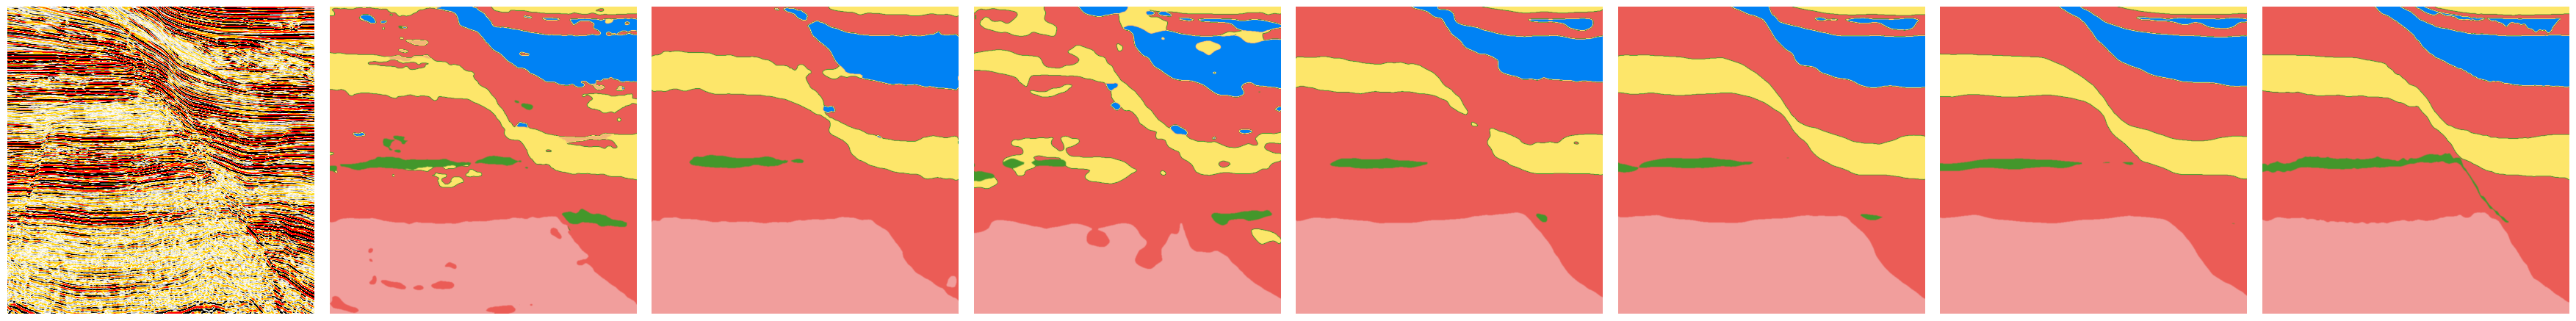

In [50]:
torch.manual_seed(42)
pred,pred2,pred3,pred4,pred5 = run_one_image(d, model_vit_base, model_vit_base_scratch,model_vit_base_frozen,model_deeplab,model_unet,model_vit_base_512, label=l,cmapl=cmapl)

In [37]:
def run_index(img, model, label=None, clims=None, savefig=None):
    model.eval()
    
    x = torch.tensor(img, dtype=torch.float32)
#     x = x.unsqueeze(0)

    pred  = model(x)
    pred  = pred.argmax(dim=1).detach().cpu()
    print(pred.shape)
    pred = pred.squeeze(0)
    return pred.numpy()
#     return pred

In [39]:
dd = np.zeros((5, 1, 768, 768))
predall = np.zeros((17, 768, 768)).astype('int64')

# loop through data
for j, start_idx in enumerate(range(100, 115, 5)):
    end_idx = start_idx + 5
    for i in range(start_idx, end_idx):
        d = np.fromfile(data_list[i], np.float32)
        d = d.reshape([1] + [768,768])
        dd[i-start_idx] = d

    # run prediction for current batch
    predall[j*5:j*5+5] = run_index(dd, model_vit_base_512)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet

# last batch (only has 2 data samples)
dd = np.zeros((2, 1, 768, 768))
for i in range(115, 117):
    d = np.fromfile(data_list[i], np.float32)
    d = d.reshape([1] + [768,768])
    dd[i-115] = d
predall[15:17] = run_index(dd, model_vit_base_512)#model_vit_finetune, model_vit_scartch,model_deeplab,model_unet


torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([5, 768, 768])
torch.Size([2, 768, 768])


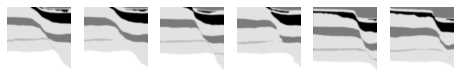

In [40]:
lll = np.zeros((17,768,768)).astype('int32')
for i in range(100,117):
    l = np.fromfile(label_list[i], np.float32).reshape([768,768])-1
    l = l.astype('int32')
    lll[i-100] = l
# predall800 = predall
plt.subplot(1,6,1)
show_image(lll[0], vmin=0, vmax=5)
plt.subplot(1,6,2)
show_image(predall[0], vmin=0, vmax=5)
plt.subplot(1,6,3)
show_image(lll[5], vmin=0, vmax=5)
plt.subplot(1,6,4)
show_image(predall[5], vmin=0, vmax=5)
plt.subplot(1,6,5)
show_image(lll[15], vmin=0, vmax=5)
plt.subplot(1,6,6)
show_image(predall[15], vmin=0, vmax=5)

In [41]:
pa_base_512,cpa_base_512,mpa_base_512,IoU_base_512,mIoU_base_512 = [],[],[],[],[]
metricall = SegmentationMetric(6)  # 2表示有2个分类，有几个分类就填几
for i in range(17):
    histall = metricall.addBatch(predall[i].astype('int64'), lll[i])
    pa_base_512.append(metricall.pixelAccuracy())
    cpa_base_512.append(metricall.classPixelAccuracy())
    mpa_base_512.append(metricall.meanPixelAccuracy())
    IoU_base_512.append(metricall.IntersectionOverUnion())
    mIoU_base_512.append(metricall.meanIntersectionOverUnion())

../../util/metrics.py:32: RuntimeWarning: invalid value encountered in true_divide
  classAcc = np.diag(self.confusionMatrix) / self.confusionMatrix.sum(axis=1)
../../util/metrics.py:50: RuntimeWarning: invalid value encountered in true_divide
  IoU = intersection / union  # 返回列表，其值为各个类别的IoU


In [6]:
print(np.mean(mIoU_base_512),np.mean(mIoU_base),np.mean(mIoU_base_forzen),
      np.mean(mIoU_base_scratch),np.mean(mIoU_unet),np.mean(mIoU_deeplab))
print(np.mean(pa_base_512),np.mean(pa_base),np.mean(pa_base_forzen),
      np.mean(pa_base_scratch),np.mean(pa_unet),np.mean(pa_deeplab))

0.7980054852182666 0.7294223219883085 0.6416886097326991 0.48577053701921913 0.5851129252713027 0.5563357864127978
0.942974696748215 0.9376599262607676 0.9148019227150467 0.7822085492892688 0.8779187863215997 0.8618552086594287


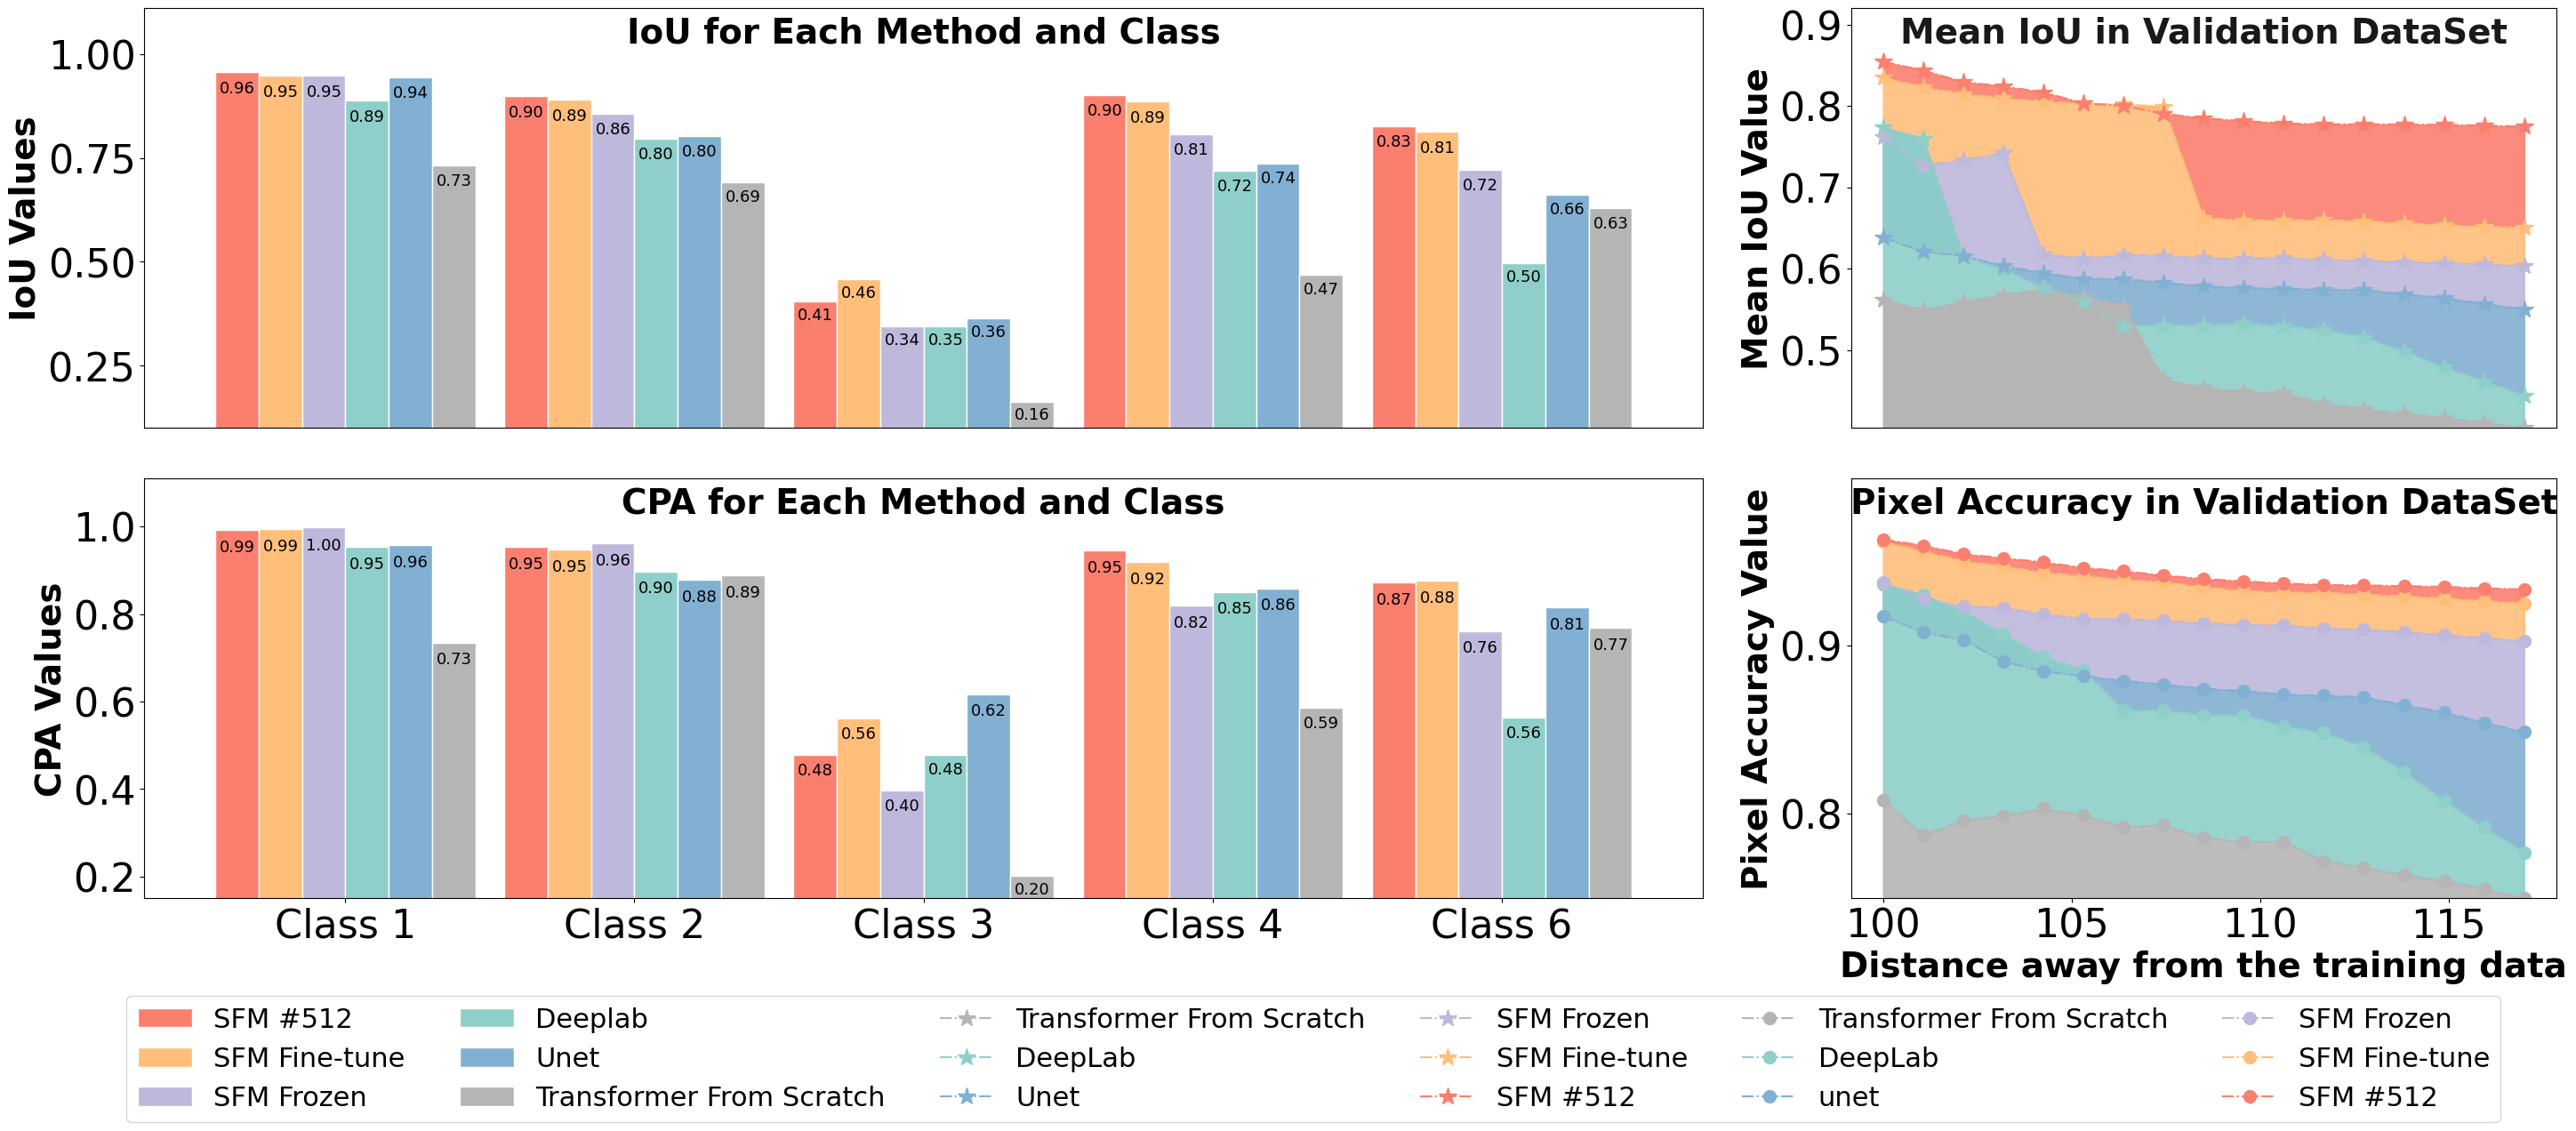

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import MultipleLocator
plt.style.use('default')
matplotlib.rcParams.update({'font.size': 32})
plt.rcParams['font.sans-serif']=['Promote']
# plt.rcParams['font.weight']=50
plt.figure(figsize=(35,13))

data = [np.delete(np.mean(IoU_base_512,axis=0),4),np.delete(np.mean(IoU_base,axis=0),4),
        np.delete(np.mean(IoU_base_forzen,axis=0),4),np.delete(np.mean(IoU_deeplab,axis=0),4),
        np.delete(np.mean(IoU_unet,axis=0),4),np.delete(np.mean(IoU_base_scratch,axis=0),4)]

# prepare the data in dataframe format
df = pd.DataFrame(data, columns=['Class 1', 'Class 2', 'Class 3', 'Class 4',  'Class 6'])
df.insert(0, 'Method', ['Transformer 512', 'Transformer PreTrain', 'Transformer Forzen', 'Deeplab','Unet','Transformer Scratch'])

# set the style of the plot
# plt.style.use('seaborn')

# set the width of each bar
barWidth = 0.15
# set the height of each bar
bars1 = df.iloc[0, 1:].tolist()
bars2 = df.iloc[1, 1:].tolist()
bars3 = df.iloc[2, 1:].tolist()
bars4 = df.iloc[3, 1:].tolist()
bars5 = df.iloc[4, 1:].tolist()
bars6 = df.iloc[5, 1:].tolist()


# set the x positions of each bar
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

ax1 = plt.subplot2grid((2,3), (0, 0),colspan = 2)
ax2 = plt.subplot2grid((2,3), (1, 0),colspan = 2)
ax3 = plt.subplot2grid((2,3), (0, 2))
ax4 = plt.subplot2grid((2,3), (1, 2))

# plot the bars
#把四个柱子的颜色改为#8ECFC9,#FFBE7A,#FA7F6F,#82B0D2
w = ax1.bar(r1, bars1, color='#FA7F6F', width=barWidth, edgecolor='white', label='SFM #512')
w1 = ax1.bar(r2, bars2, color='#FFBE7A', width=barWidth, edgecolor='white', label='SFM Fine-tune')
w2 = ax1.bar(r3, bars3, color='#BEB8DC', width=barWidth, edgecolor='white', label='SFM Frozen')
w3 =ax1.bar(r4, bars4, color='#8ECFC9', width=barWidth, edgecolor='white', label='Deeplab')
w4 =ax1.bar(r5, bars5, color='#82B0D2', width=barWidth, edgecolor='white', label='Unet') #'#F7E1ED'
w5 =ax1.bar(r6, bars6, color='#b5b5b5', width=barWidth, edgecolor='white', label='Transformer From Scratch')

def autolabel(listrect):
    for rects in listrect:
        for rect in rects:
            height = rect.get_height()
    #         print(height)
            if np.isnan(height) or height==0:
                continue
            ax1.text(rect.get_x()+rect.get_width()/2.-0.06, 0.99*height-0.04, '%0.2f' % height, size=13)#,fontweight='bold')

autolabel([w,w1,w2,w3,w4,w5])
# set the x axis labels
# ax1.set_xlabel('Classes',fontsize=28)
# ax1.set_xticks([r + barWidth for r in range(len(bars1))], df.columns[1:])
# set the y axis label
# ax1.set_xticks([r + 2.5*barWidth for r in range(len(bars1))])#, 
# ax1.set_xticklabels(df.columns[1:])
ax1.set_xticks([])

# ax1.set_xlim(0.1,1)
ax1.set_ylabel('IoU Values',fontsize=28,fontweight='bold')
ax1.set_title('IoU for Each Method and Class',fontsize=28,fontweight='bold',x=0.5,y=0.9)
ax1.set_ylim(0.1,1.11)

data = [np.delete(np.mean(cpa_base_512,axis=0),4),np.delete(np.mean(cpa_base,axis=0),4),
        np.delete(np.mean(cpa_base_forzen,axis=0),4),np.delete(np.mean(cpa_deeplab,axis=0),4),
        np.delete(np.mean(cpa_unet,axis=0),4),np.delete(np.mean(cpa_base_scratch,axis=0),4)]

# prepare the data in dataframe format
df = pd.DataFrame(data, columns=['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 6'])
df.insert(0, 'Method', ['Transformer 512', 'Transformer PreTrain', 'Transformer Forzen', 'Deeplab','Unet','Transformer Scratch'])

# set the style of the plot


# set the width of each bar
barWidth = 0.15

# set the height of each bar
bars1 = df.iloc[0, 1:].tolist()
bars2 = df.iloc[1, 1:].tolist()
bars3 = df.iloc[2, 1:].tolist()
bars4 = df.iloc[3, 1:].tolist()
bars5 = df.iloc[4, 1:].tolist()
bars6 = df.iloc[5, 1:].tolist()

# set the x positions of each bar
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]
r5 = [x + barWidth for x in r4]
r6 = [x + barWidth for x in r5]

w  = ax2.bar(r1, bars1, color='#FA7F6F', width=barWidth, edgecolor='white', label='SFM #512')
w1 = ax2.bar(r2, bars2, color='#FFBE7A', width=barWidth, edgecolor='white', label='SFM Fine-tune')
w2 = ax2.bar(r3, bars3, color='#BEB8DC', width=barWidth, edgecolor='white', label='SFM Frozen')
w3 = ax2.bar(r4, bars4, color='#8ECFC9', width=barWidth, edgecolor='white', label='Deeplab')
w4 = ax2.bar(r5, bars5, color='#82B0D2', width=barWidth, edgecolor='white', label='Unet')
w5 = ax2.bar(r6, bars6, color='#b5b5b5', width=barWidth, edgecolor='white', label='Transformer From Scratch')

def autolabel2(listrect):
    for rects in listrect:
        for rect in rects:
            height = rect.get_height()
    #         print(height)
            if np.isnan(height):
                continue
            ax2.text(rect.get_x()+rect.get_width()/2.-0.06, 0.99*height-0.04, '%0.2f' % height, size=13)#,fontweight='bold')#,rotation=90)

autolabel2([w,w1,w2,w3,w4,w5])

# set the x axis labels
# ax2.set_xlabel('Classes',fontsize=28)
ax2.set_xticks([r + 2.5*barWidth for r in range(len(bars1))])#, 
ax2.set_xticklabels(df.columns[1:])
# set the y axis label
ax2.set_ylabel('CPA Values',fontsize=28,fontweight='bold')
ax2.set_title('CPA for Each Method and Class',fontsize=28,fontweight='bold',x=0.5,y=0.9)
ax2.set_ylim(0.15,1.11)
ax2.set_xticklabels(df.columns[1:])


# add a legend to the plot
# ax2.legend(loc='upper right', bbox_to_anchor=(1.0, 1.05),fontsize=28,ncol=1)
N = 17
x = np.linspace(100, 117, N)
# pa_all

# ax3.figure(figsize=(12,12))
ax3.plot(x, mIoU_base_scratch, '*', ls = '-.', ms = 15, markevery = 1, color='#b5b5b5', label = r'Transformer From Scratch')
ax3.plot(x, mIoU_deeplab, '*', ls = '-.', ms = 15, markevery = 1, color='#8ECFC9', label = r'DeepLab')
ax3.plot(x, mIoU_unet, '*', ls = '-.', ms = 15, markevery = 1, color='#82B0D2', label = r'Unet')
ax3.plot(x, mIoU_base_forzen, '*', ls = '-.', ms = 15, markevery = 1, color='#BEB8DC', label = r'SFM Frozen')
ax3.plot(x, mIoU_base, '*', ls = '-.', ms = 15, markevery = 1,color='#FFBE7A', label = r'SFM Fine-tune')
ax3.plot(x, mIoU_base_512, '*', ls = '-.', ms = 15, markevery = 1, color='#FA7F6F', label = r'SFM #512')

# ax=plt.gca()
x_major_locator=MultipleLocator(5)
y_major_locator=MultipleLocator(0.1)

# ax3.xaxis.set_major_locator(x_major_locator)
ax3.yaxis.set_major_locator(y_major_locator)
ax3.fill_between(x, mIoU_base_512, mIoU_base, color='#FA7F6F',alpha=0.9)
ax3.fill_between(x, mIoU_base, mIoU_base_forzen, color='#FFBE7A',alpha=0.9)
ax3.fill_between(x, mIoU_base_forzen, mIoU_unet, color='#BEB8DC',alpha=0.9)
ax3.fill_between(x, mIoU_unet, mIoU_deeplab, color='#82B0D2',alpha=0.9)
ax3.fill_between(x, mIoU_deeplab, mIoU_base_scratch, color='#8ECFC9',alpha=0.9)
ax3.fill_between(x, mIoU_base_scratch, np.min(mIoU_base_scratch), color='#b5b5b5')
# plt.axis('equal')
ax3.set_ylabel('Mean IoU Value',fontsize=28,fontweight='bold')
ax3.set_xticks([])
ax3.set_ylim(np.min(mIoU_base_scratch),0.92)
# ax3.set_xlabel('Data Index in Validation DataSet ',fontsize=28,fontweight='bold')
ax3.set_title('Mean IoU in Validation DataSet',fontsize=28,fontweight='bold',alpha=0.9,x=0.5,y=0.9)

# plt.legend()
# ax3.legend(bbox_to_anchor=(1.01, 1),fontsize=28)
ax4.plot(x, pa_base_scratch, 'o', ls = '-.', ms = 10, markevery = 1, color='#b5b5b5', label = r'Transformer From Scratch')
ax4.plot(x, pa_deeplab, 'o', ls = '-.', ms = 10, markevery = 1, color='#8ECFC9', label = r'DeepLab')
ax4.plot(x, pa_unet, 'o', ls = '-.', ms = 10, markevery = 1, color='#82B0D2', label = r'unet')
ax4.plot(x, pa_base_forzen, 'o', ls = '-.', ms = 10, markevery = 1, color='#BEB8DC', label = r'SFM Frozen')
ax4.plot(x, pa_base, 'o', ls = '-.', ms = 10, markevery = 1,color='#FFBE7A', label = r'SFM Fine-tune')
ax4.plot(x, pa_base_512, 'o', ls = '-.', ms = 10, markevery = 1, color='#FA7F6F', label = r'SFM #512 ')

x_major_locator=MultipleLocator(5)
y_major_locator=MultipleLocator(0.1)
ax4.xaxis.set_major_locator(x_major_locator)
ax4.yaxis.set_major_locator(y_major_locator)

# plt.axis('equal')
ax4.set_ylabel('Pixel Accuracy Value',fontsize=28,fontweight='bold')
ax4.set_xlabel('Distance away from the training data',fontsize=28,fontweight='bold')
ax4.fill_between(x, pa_base_512, pa_base, color='#FA7F6F',alpha=0.9)
ax4.fill_between(x, pa_base, pa_base_forzen, color='#FFBE7A',alpha=0.9)
ax4.fill_between(x, pa_base_forzen, pa_unet, color='#BEB8DC',alpha=0.9)
ax4.fill_between(x, pa_unet, pa_deeplab, color='#82B0D2',alpha=0.9)
ax4.fill_between(x, pa_deeplab, pa_base_scratch, color='#8ECFC9',alpha=0.9)
ax4.fill_between(x, pa_base_scratch, np.min(pa_base_scratch), color='#b5b5b5',alpha=0.9)

ax4.set_title('Pixel Accuracy in Validation DataSet',fontsize=28,fontweight='bold',x=0.5,y=0.9)
ax4.set_ylim(np.min(pa_base_scratch),0.999)


# plt.legend()
lines,labels = [],[]
for ax in [ax1,ax3,ax4]:
    axLine, axLabel = ax.get_legend_handles_labels()
    lines.extend(axLine)
    labels.extend(axLabel)
    
# ax4.legend(bbox_to_anchor=(1.01, 1),fontsize=18)
# ax4.legend(lines, labels,bbox_to_anchor=(1.01, 1),fontsize=18)
# ax3.legend(loc='upper left',bbox_to_anchor=(-0.05, -0.1),fontsize=28,ncol=2)
ax2.legend(lines, labels,loc='upper left', bbox_to_anchor=(-0.02, -0.2),fontsize=22,ncol=6)
# ax4.legend(loc='upper left',bbox_to_anchor=(0.0, -0.1),fontsize=28,ncol=2)
# ax3.legend(bbox_to_anchor=(2, 1),fontsize=18)
plt.subplots_adjust(wspace=0.21, hspace=0.12)
# plt.rcParams['axes.facecolor'] = 'white'
# ax1.set_facecolor('white')
# set the title of the plot

# show the plot
# plt.show()


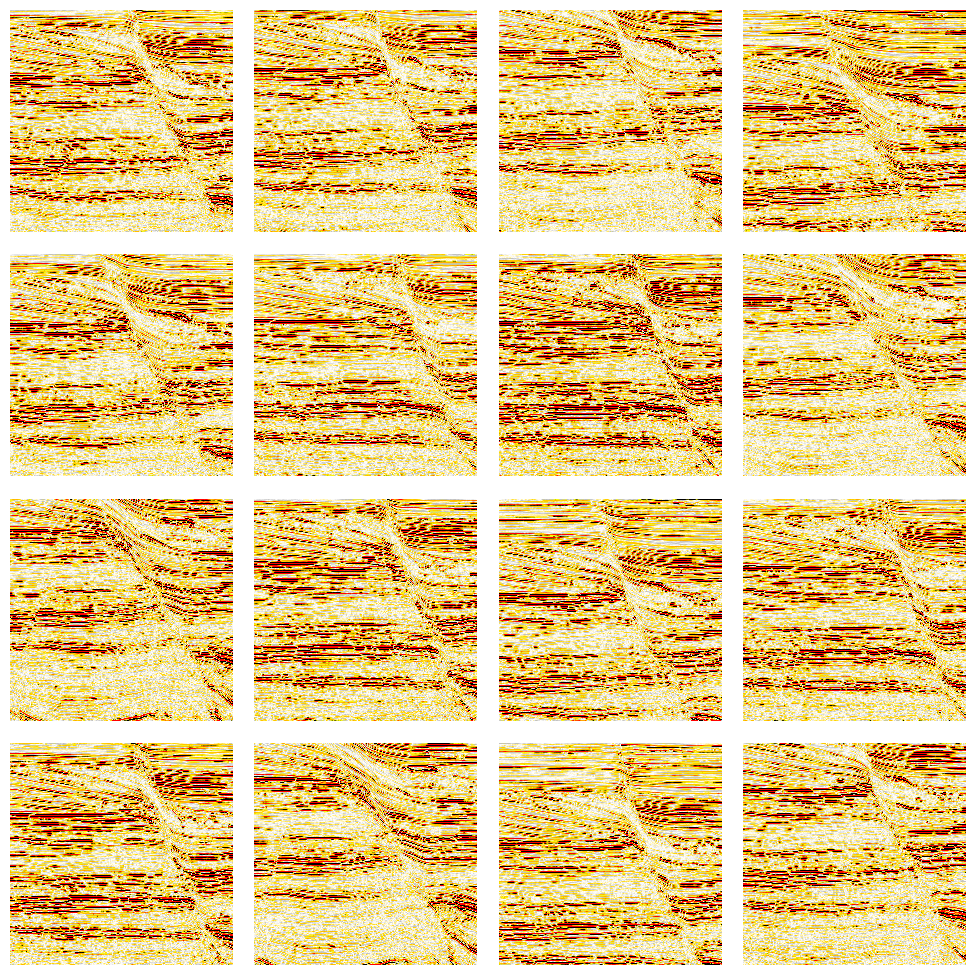

In [68]:
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib as mpl

# color_list = ['red','orange','gold','white','silver','gray','black']
color_list = ['black','yellow','silver','white','gold','orange','red']
cmap = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)


data_path = '../Data/Facies/' +'seismic/'
label_path = '../Data/Facies/' +'label/'
data_files =  [str(f)+'.dat' for f in range(100,117)]
selected_files = random.sample(data_files, 16) # Random Select files to show


fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(data_path, selected_files[i]), 'rb') as f:
        
        data = np.fromfile(f, dtype=np.single)
        data = data.reshape((768, 768))
        ax.imshow(data, cmap=cmap,vmin=np.min(data)/10,vmax=-np.min(data)/10)
        ax.axis('off')
# 显示整个图像
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()

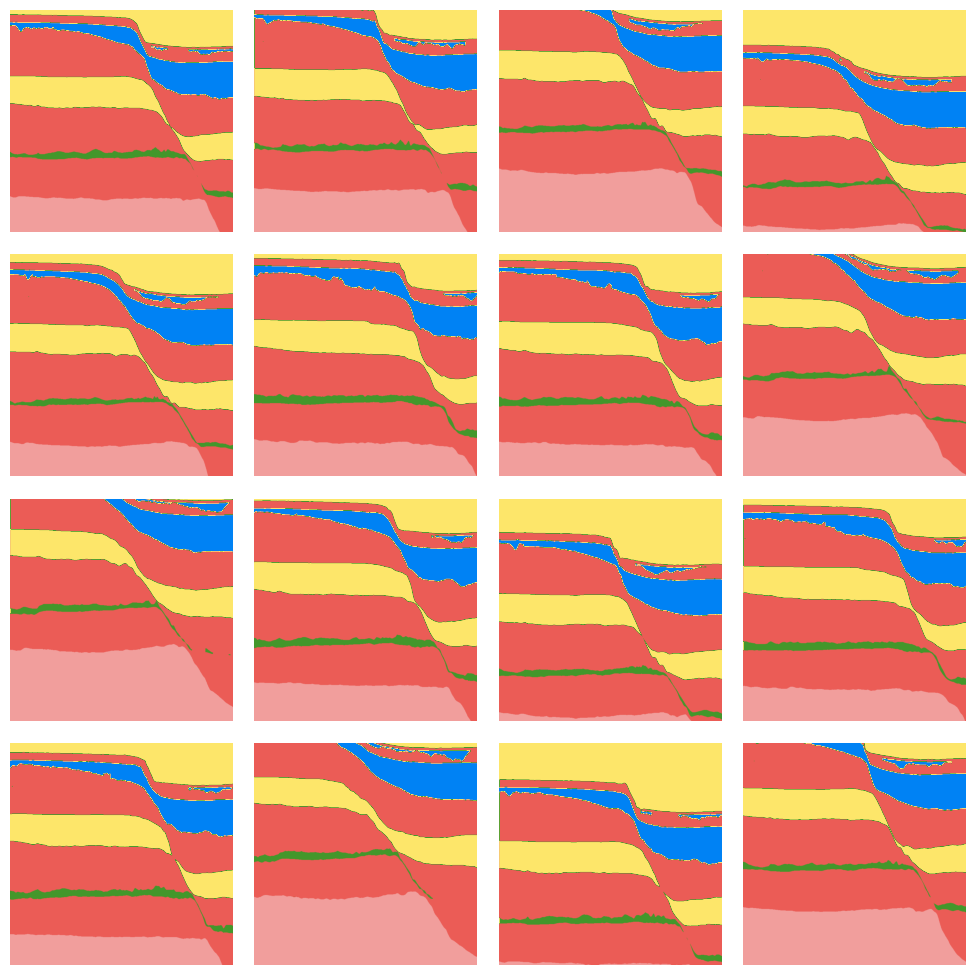

In [69]:
color_list = ['#F19E9C','#EB5C56','#43972B','#FEE76B','#F3B677','#0082F4'] #seam
cmapl = mpl.colors.LinearSegmentedColormap.from_list('colormap_name', color_list)
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axes.flatten()):
    with open(os.path.join(label_path, selected_files[i]), 'rb') as f:
        data = np.fromfile(f, dtype=np.single)-1
        data = data.reshape((768, 768))
        ax.imshow(data, cmap=cmapl)#,vmin=np.min(data)/2,vmax=-np.min(data)/2)
        ax.axis('off')
plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()